# Module installation and loading

In [26]:
# This will install the packages needed for the HW (if these are not installed yet)
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install tqdm
!{sys.executable} -m pip install matplotlib
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 18})
# The following lines import LaTeX packages to make plots nicer.
UseLaTeX = False # This can be set to "True" if LaTeX is available on your computer
if UseLaTeX:
  plt.rcParams['text.usetex'] = True
  plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb} \usepackage{color}')

# Loading up HIT data and computing flow statistics

In [27]:
loaded_data = np.load('../Flow_Data/hit/ae598-mf-hw3-data.npz') # If your data file is located in a separate folder, you need to provide the full path to the file
L                            = float(loaded_data['L']) # Domain length
nx                           = int(loaded_data['nx']) # Number of cells per direction
dx                           = L/float(nx) # Mesh spacing
nu                           = float(loaded_data['nu']) # Kinematic viscosity
vel                          = np.array(loaded_data['velocity'].reshape((nx,nx,nx,3),order='F'),dtype=np.float32) # Load velocity from data file
ng                           = 3 # Number of ghost layers for interpolation and gradient calculation
velg                         = np.pad(vel, ((ng,ng),(ng,ng),(ng,ng),(0,0)), 'wrap') # Padding domain with 'ng' periodic ghost layers
u, v, w                      = vel[:,:,:,0],  vel[:,:,:,1],  vel[:,:,:,2] # Velocity components
vel_mag                      = np.sqrt(u**2+v**2+w**2) # Velocity magnitude
ug, vg, wg                   = velg[:,:,:,0], velg[:,:,:,1], velg[:,:,:,2] # Velocity components with ghost layer padding (needed for gradient)
# Compute velocity gradient
grad_u_x, grad_u_y, grad_u_z = np.array(np.gradient(ug, dx))[:,ng:-ng,ng:-ng,ng:-ng]
grad_v_x, grad_v_y, grad_v_z = np.array(np.gradient(vg, dx))[:,ng:-ng,ng:-ng,ng:-ng]
grad_w_x, grad_w_y, grad_w_z = np.array(np.gradient(wg, dx))[:,ng:-ng,ng:-ng,ng:-ng]
# Compute turbulent kinetic energy and dissipation rate
tke                          = 0.5*np.mean(u**2+v**2+w**2)
eps                          = 2.0*nu*np.mean(grad_u_x**2+grad_v_y**2+grad_w_z**2+0.25*(grad_u_y+grad_v_x)**2+0.25*(grad_u_z+grad_w_x)**2+0.25*(grad_v_z+grad_w_y)**2)
# Compute Taylor-scale Reynolds number and flow length- and time-scales
u_rms                        = np.sqrt(2.0*tke/3.0) # RMS turbulent velocity [m/s]
Taylor_lambda                = np.sqrt(15.0*nu*u_rms**2/eps)  # Taylor microscale [m]
Re_lambda                    = u_rms*Taylor_lambda/nu # Taylor-scale Reynolds number [-]
eta                          = (nu**3/eps)**0.25 # Kolmogorov length scale [m]
tau_eta                      = (nu/eps)**0.5 # Kolmogorov time scale [s]
u_eta                        = (nu*eps)**0.25 # Kolmogorov velocity scale [m/s]
L_integral                   = u_rms**3/eps # Integral length scale [m]
tau_L                        = L_integral/u_rms # Large-eddy turnover time [s]

print("Number of computational cells = %i^3    [-]" % nx)
print("                 Domain width = %.2e [m]" % L)
print("          Kinematic viscosity = %.2e [m^2/s]" % nu)
print("                 RMS velocity = %.2e [m/s]" % u_rms)
print(" Taylor-scale Reynolds number = %.2e [-]" % Re_lambda)
print("      Kolmogorov length scale = %.2e [m]" % eta)
print("        Kolmogorov time scale = %.2e [s]" % tau_eta)
print("    Kolmogorov velocity scale = %.2e [m/s]" % u_eta)
print("        Integral length scale = %.2e [m]" % L_integral)
print("           Eddy turnover time = %.2e [s]" % tau_L)

Number of computational cells = 128^3    [-]
                 Domain width = 1.00e-01 [m]
          Kinematic viscosity = 1.00e-05 [m^2/s]
                 RMS velocity = 1.01e-01 [m/s]
 Taylor-scale Reynolds number = 6.99e+01 [-]
      Kolmogorov length scale = 4.20e-04 [m]
        Kolmogorov time scale = 1.76e-02 [s]
    Kolmogorov velocity scale = 2.38e-02 [m/s]
        Integral length scale = 3.22e-02 [m]
           Eddy turnover time = 3.18e-01 [s]


# Visualizing slice of velocity data

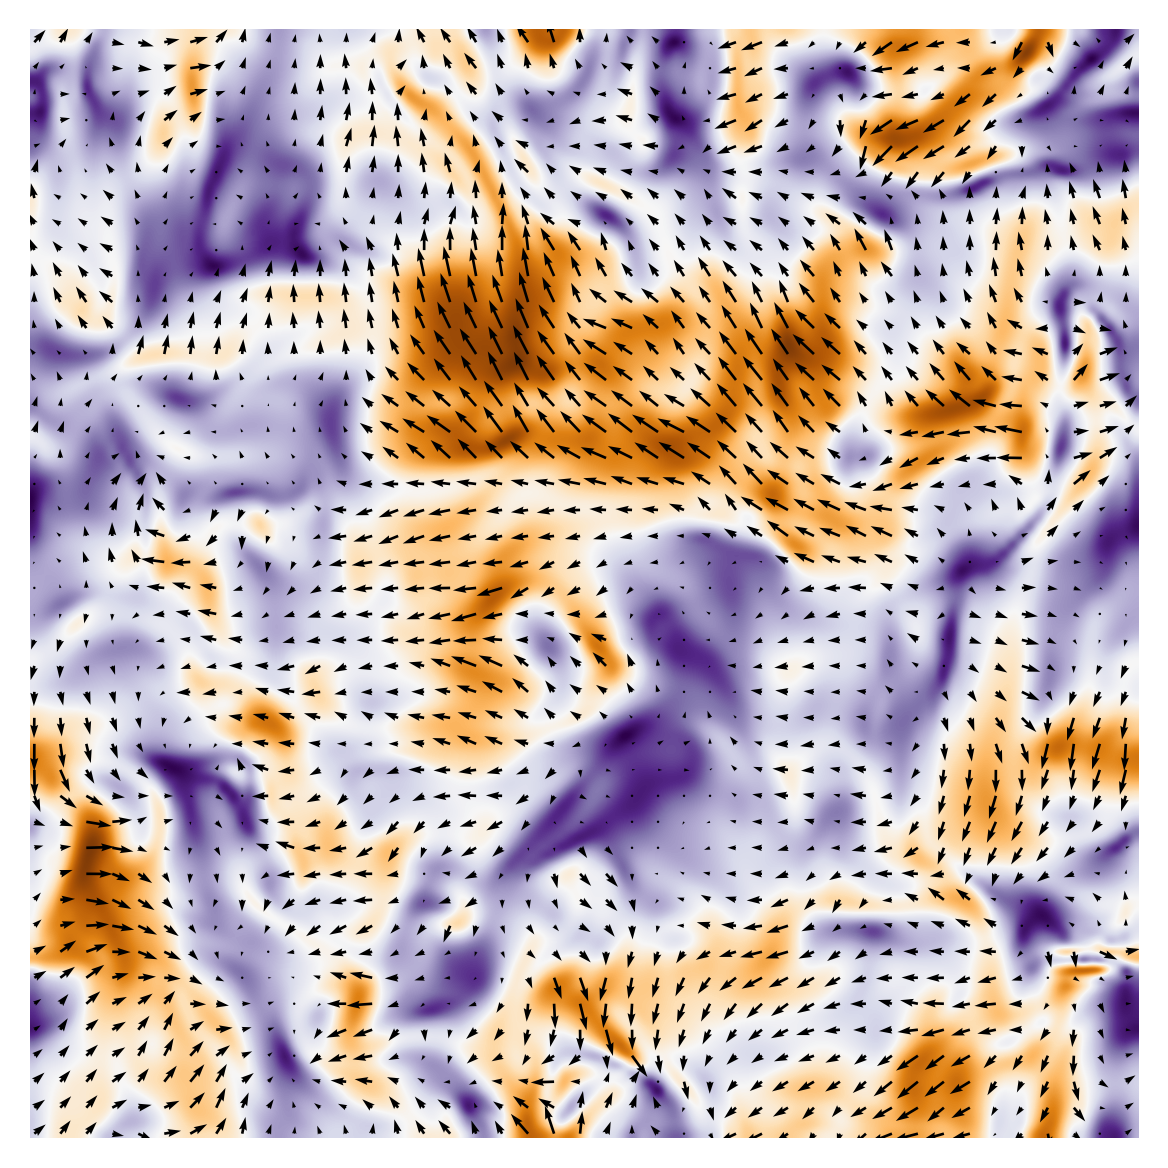

In [28]:
# Plot and save slice of the simulations snapshot
plt.imshow(vel_mag[:,:,0], interpolation='spline36', cmap='PuOr_r', origin='lower', extent=[0, L, 0, L])
x_coords = 0.5*dx + np.linspace(0, L, nx, endpoint=False); X, Y = np.meshgrid(x_coords, x_coords)
plt.quiver(X[::3,::3], Y[::3,::3], u[::3,::3,-1],v[::3,::3,-1],color='black'); plt.axis('off')
plt.savefig("../Results/hit.pdf", dpi=600, bbox_inches='tight', pad_inches=0) 

# Velocity interpolation operator

In [29]:
# Linear velocity interpolator -> return fluid velocity interpolated at locations x
def fluid_velocity_interpolator(x): # Shape of input "x" is (N,3)
  xmod    = np.mod(x,L)
  indices = np.int_(np.floor(xmod/dx))
  phi     = (xmod - indices*dx)/dx
  up      = phi[:,0]*(ug[ng+indices[:,0]+1,ng+indices[:,1],ng+indices[:,2]]) +(1.0-phi[:,0])*(ug[ng+indices[:,0],ng+indices[:,1],ng+indices[:,2]])
  vp      = phi[:,1]*(vg[ng+indices[:,0],ng+indices[:,1]+1,ng+indices[:,2]]) +(1.0-phi[:,1])*(vg[ng+indices[:,0],ng+indices[:,1],ng+indices[:,2]])
  wp      = phi[:,2]*(wg[ng+indices[:,0],ng+indices[:,1],ng+indices[:,2]+1]) +(1.0-phi[:,2])*(wg[ng+indices[:,0],ng+indices[:,1],ng+indices[:,2]])
  return np.swapaxes(np.array([up,vp,wp]),0,1)

# Fluid tracer particle tracker

In [30]:
# This function integrates in time the position of fluid traces
# It solves dx(t)/dt = u(x(t)) with an RK2 scheme
def fluid_tracer_solver(x0,dt,Nt,save_velocity_history=False): # Shape of input "x0" is (N,3)
  N = len(x0)
  if save_velocity_history: part_v = np.zeros((Nt,N,3))
  # Initialize particle position and velocity
  part_x = np.copy(x0); 
  if save_velocity_history: part_v[0,:,:] = fluid_velocity_interpolator(x0)
  # Loop over timesteps
  for i in tqdm(range(1,Nt)):
    k1 = dt*fluid_velocity_interpolator(part_x)
    part_x += dt*fluid_velocity_interpolator(part_x+0.5*k1)
    if save_velocity_history: part_v[i,:,:] = fluid_velocity_interpolator(part_x)
  if save_velocity_history: return part_x, part_v
  else: return part_x

# Advancing 500,000 fluid tracers forward in time for 2 eddy turnover times

In [31]:
# Track fluid tracer particles and verify that they do not cluster
Npart = 5000
T = 2*tau_L
scaling_dt = 1/20
dt = scaling_dt*tau_eta
Nt = int(np.ceil(T/dt))

# Initial random fluid tracer locations in [0,L]^3
part_x0 = np.reshape(L*np.random.rand(3*Npart),(Npart,3))

# Advance fluid tracers to t=T
part_x = fluid_tracer_solver(part_x0,dt,Nt) # This may take several minutes to run

100%|██████████| 721/721 [00:00<00:00, 929.38it/s]


# Plotting initial and final particle distributions in a slice of thickness $5\eta$

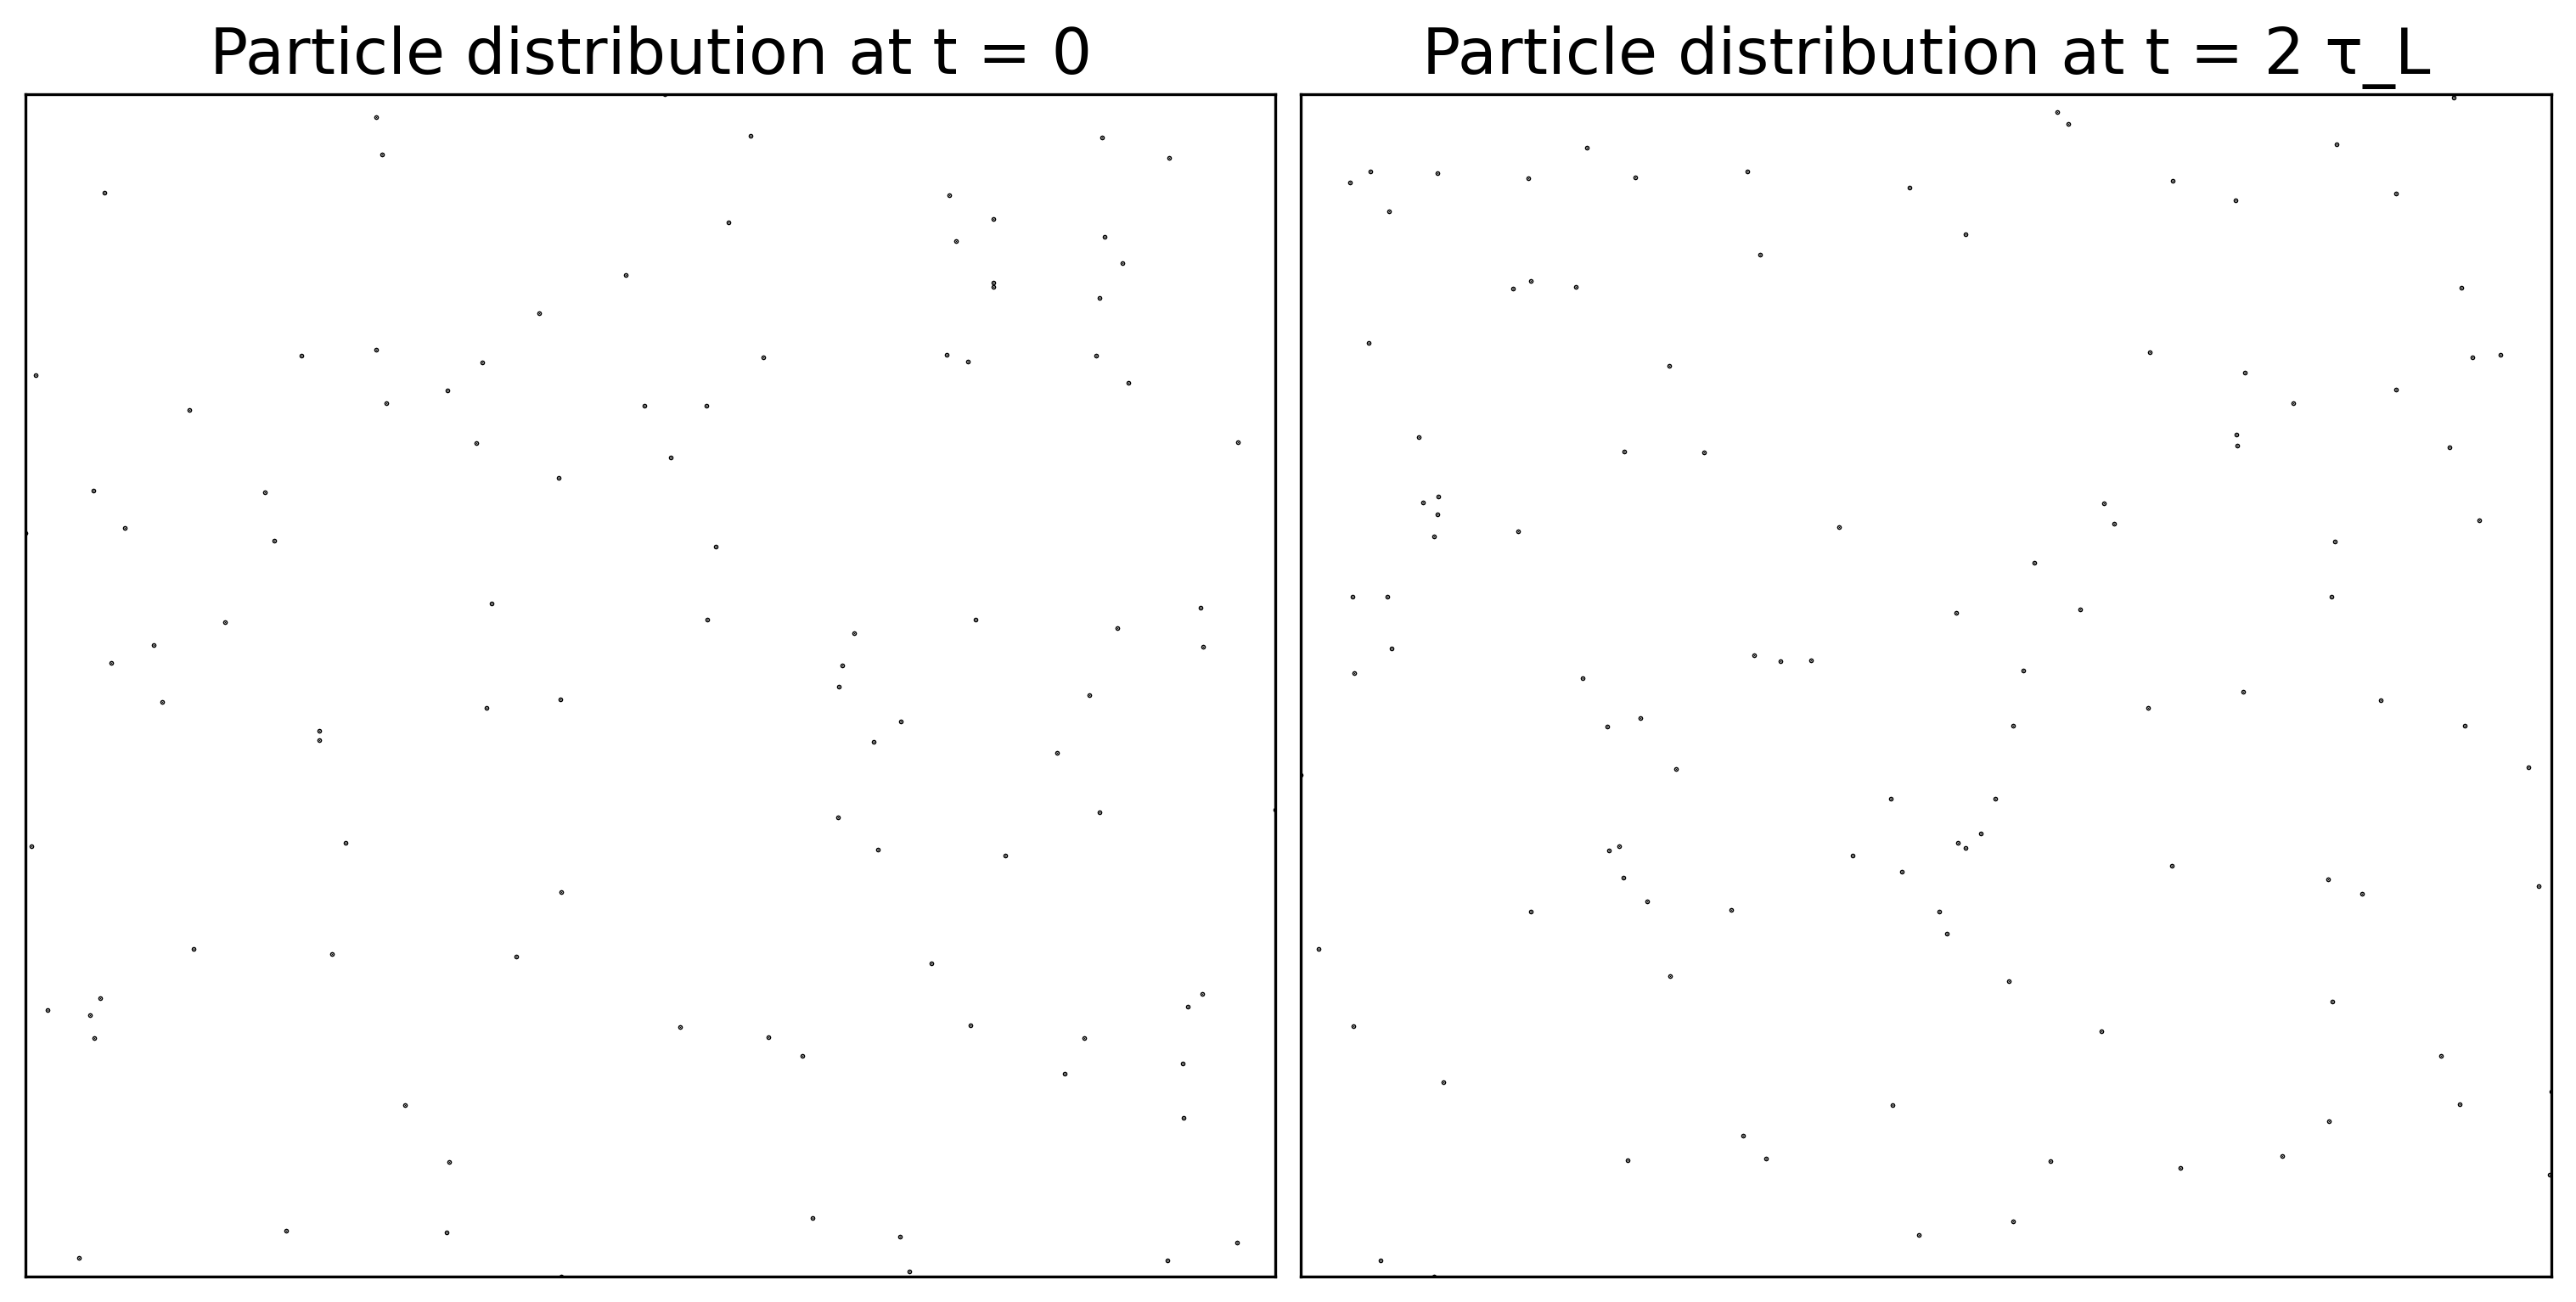

In [32]:
# This function plots particles located in a domain slice of given thickness
def plot_particles(ax, position, z_slice_location, z_slice_thickness, title=''):
  # Compute particle locations modulo L (so that position is inside [0,L]^3)
  x = np.mod(position[:,0],L); y = np.mod(position[:,1],L); z = np.mod(position[:,2],L)
  # Create mask for particles inside the slice with provided thickness
  mask = np.abs(z-z_slice_location) > 0.5*z_slice_thickness
  # Plot all particles in slice
  ax.scatter(np.ma.MaskedArray(x, mask),np.ma.MaskedArray(y, mask),s=0.125,color='k')
  # Set plot title
  ax.set_title(title, fontsize=18); ax.margins(0); ax.set_xticks([]); ax.set_yticks([])

# Create figure with 2 subfigures for before/after
fig = plt.figure(layout='constrained', figsize=(10, 5)); subfigs = fig.subplots(1, 2)
# Initialize slice paramters
slice_loc = 0.25*L
slice_thickness = 5.0*eta
# Print initial particle distribution
if UseLaTeX:
  time_init_string = r'$t = 0$'
  time_final_string = r'$t = 2 \tau_L$'
else:
  time_init_string = 't = 0'
  time_final_string = 't = 2 τ_L'
plot_particles(subfigs[0], part_x0, slice_loc, slice_thickness, r'Particle distribution at %s' % time_init_string)
# Print final particle distribution
plot_particles(subfigs[1], part_x, slice_loc, slice_thickness, r'Particle distribution at %s' % time_final_string)
# Save figure for HW report
plt.savefig("../Results/tracers.pdf", dpi=600, bbox_inches='tight', pad_inches=1e-1) 

# Computing Lagrangian turbulent kinetic energy spectrum

100%|██████████| 721/721 [00:05<00:00, 137.05it/s]


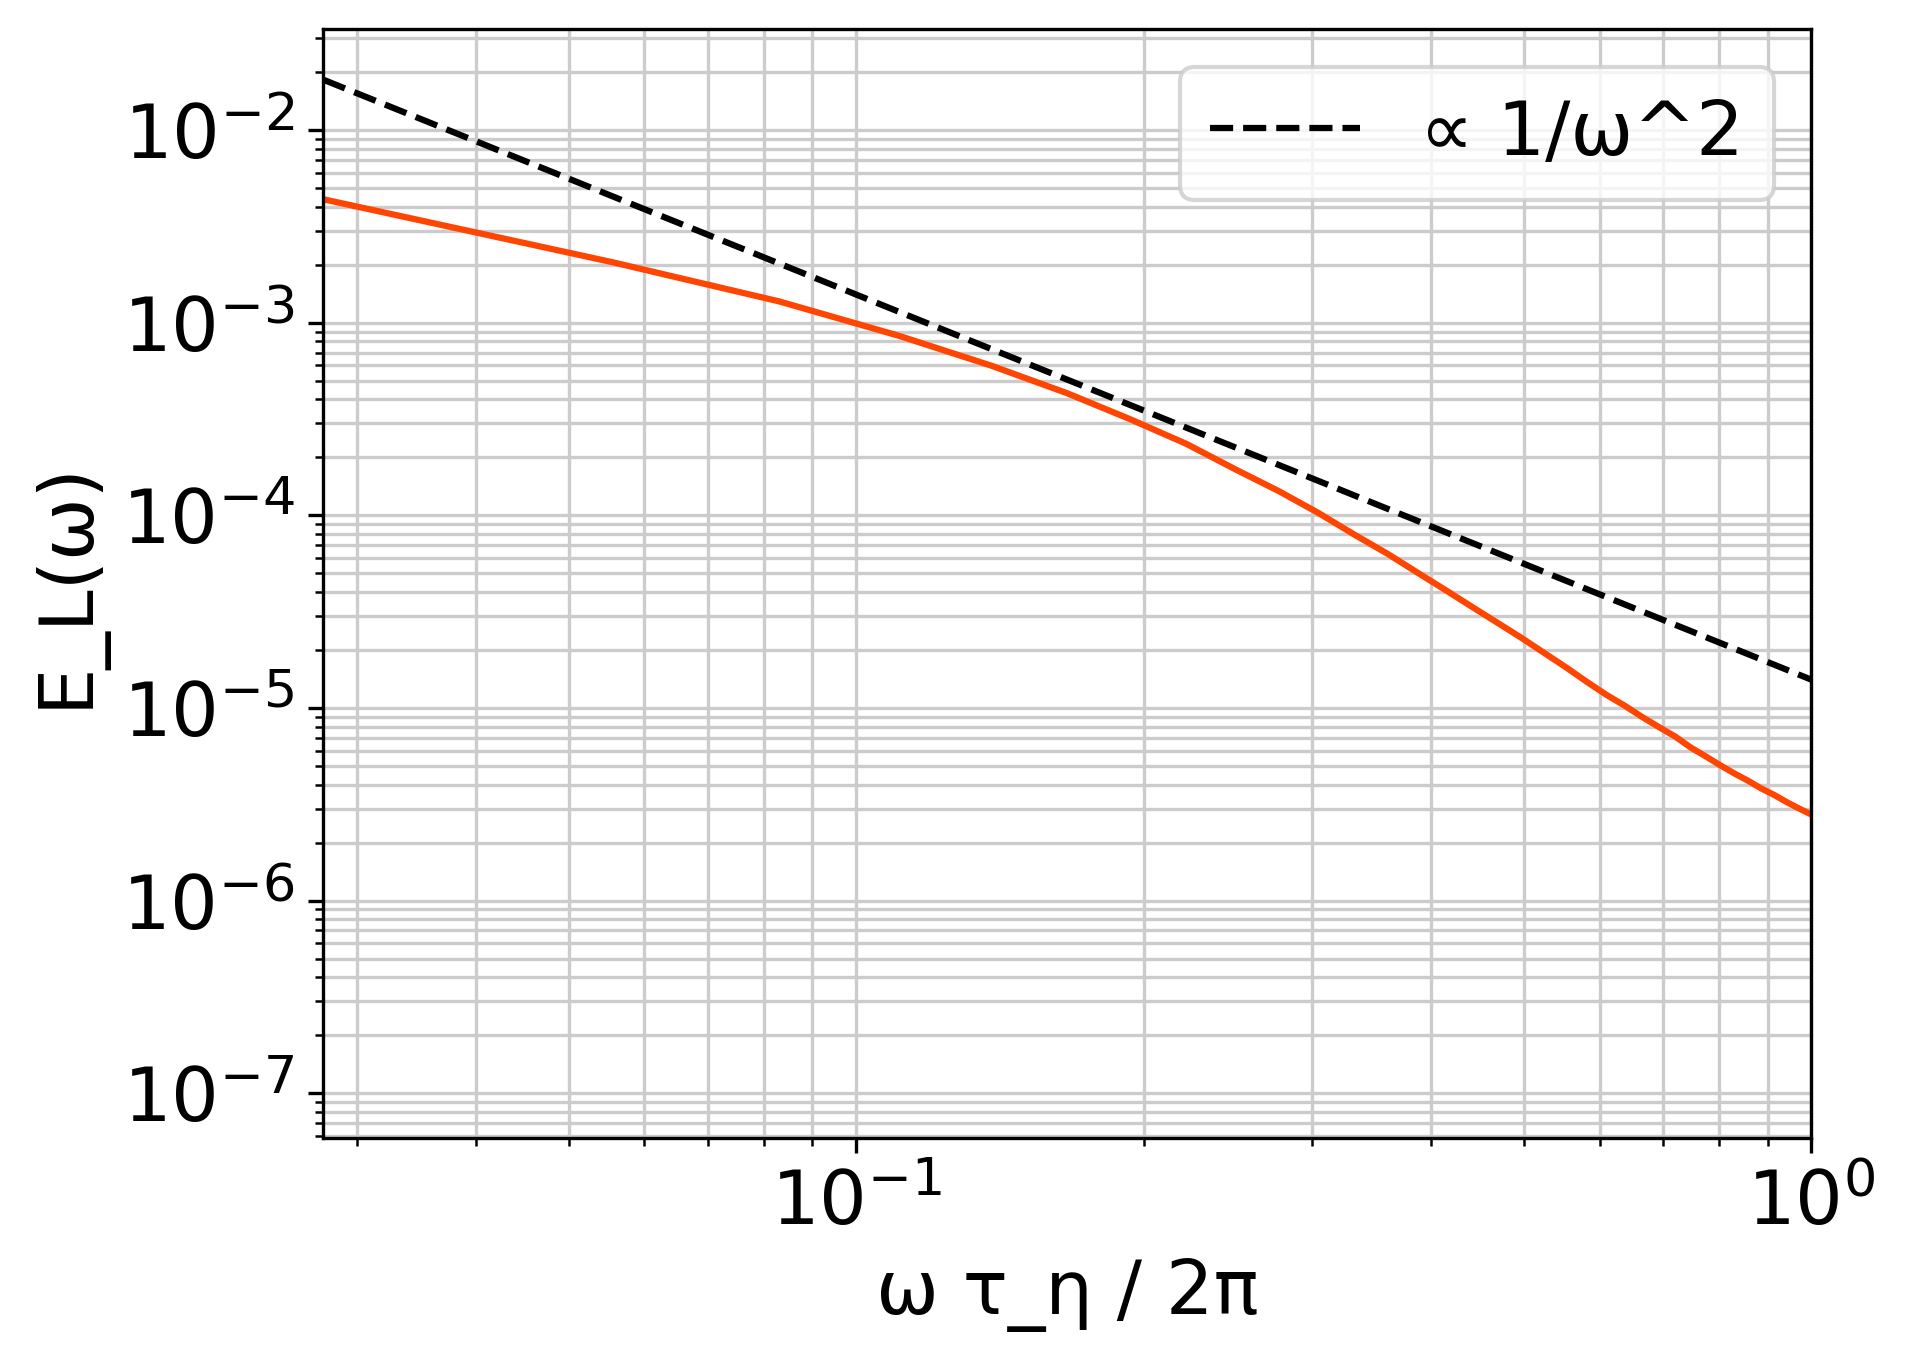

In [33]:
# Rerun this with fewer particles (to prevent running out of memory)
Npart = 20000
part_x0_spectrum = np.reshape(L*np.random.rand(3*Npart),(Npart,3))
part_x_spectrum, part_v_spectrum = fluid_tracer_solver(part_x0_spectrum,dt,Nt,True)

# Compute Fourier transforms of fluid and particle velocities for each particle
uphat, vphat, wphat = np.fft.rfft(part_v_spectrum[:,:,0], axis=0, norm="ortho"), np.fft.rfft(part_v_spectrum[:,:,1], axis=0, norm="ortho"), np.fft.rfft(part_v_spectrum[:,:,2], axis=0, norm="ortho")
# Compute frequency range
omega = np.fft.rfftfreq(Nt, d=dt)*2.0*np.pi; Nl=len(omega)
# Compute normalization frequency based on Kolmogorov timescale
omega_eta = 2.0*np.pi/tau_eta
# The Lagrangian velocity spectra are obtained from those Fourier transform directly
Elag = 0.5 * np.mean(np.abs(uphat)**2 + np.abs(vphat)**2 + np.abs(wphat)**2, axis=1)/Nl
# Plot spectra
if UseLaTeX:
  label_Elag = r'$E_L(\omega)$'
  label_omega = r'$\omega \tau_\eta / 2\pi$'
  label_order = r'$\propto \omega^{-2}$'
else:
  label_Elag = 'E_L(ω)'
  label_omega = 'ω τ_η / 2π'
  label_order = '∝ 1/ω^2'
plt.loglog(omega/omega_eta, Elag, color='orangered')
plt.loglog(omega[1:]/omega_eta, 5e-3*omega_eta/omega[1:]**2, color='k', linestyle='dashed', label=r'%s' % label_order)
plt.grid(True, which="both", ls="-", color='0.8')
plt.xlim(omega[1]/omega_eta,1)
plt.ylabel(r'%s' % label_Elag)
plt.xlabel(r'%s' % label_omega)
plt.legend()
# Save spectrum for HW report
plt.savefig("../Results/spectrum.pdf", dpi=600, bbox_inches='tight', pad_inches=1e-1) 